In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import math
from scipy.optimize import curve_fit


In [3]:
#Functions
def alpha(z):
    return np.sin(np.pi * z / (8*h))
def dBr_dz(B_r):
    return np.gradient(B_r, dz)
def d2Br_dz2(B_r):
    return np.gradient(np.gradient(B_r, dz), dz)
def d2Bphi_dz2(B_phi):
    return np.gradient(np.gradient(B_phi, dz), dz)
def dBrdt(B_r, B_phi):
    return  -(h * alpha_0 / eta_t) * dBr_dz(B_phi * alpha(z)) + d2Br_dz2(B_r)
def dBphidt(B_r, B_phi):
    return  -(h**2 * q * Omega / eta_t) * B_r + d2Bphi_dz2(B_phi)


In [4]:


def rk6_step(B_r, B_phi):#note could have written z+ah but as both eqautions are independent of z it does not mater and hence not coded
    k1_r = dt * dBrdt( B_r, B_phi)
    k1_phi = dt * dBphidt( B_r, B_phi)

    k2_r = dt * dBrdt( B_r + (1/3) * k1_r, B_phi + (1/3) * k1_phi)
    k2_phi = dt * dBphidt( B_r + (1/3) * k1_r, B_phi + (1/3) * k1_phi)

    k3_r = dt * dBrdt( B_r + (2/3) * k2_r, B_phi + (2/3) * k2_phi)
    k3_phi = dt * dBphidt( B_r + (2/3) * k2_r, B_phi + (2/3) * k2_phi)

    k4_r = dt * dBrdt( B_r+(1/12) *k1_r+(1/3) * k2_r -(1/12) * k3_r, B_phi +(1/12 )*k1_phi+(1/3) * k2_phi -(1/12) * k3_phi)
    k4_phi = dt * dBphidt( B_r+(1/12) *k1_r+(1/3) * k2_r -(1/12) * k3_r, B_phi +(1/12 )*k1_phi+(1/3) * k2_phi -(1/12) * k3_phi)

    k5_r = dt * dBrdt( B_r -(1/16) * k1_r + (9/8) * k2_r -(3/6) * k3_r - (3/8) * k4_r,
                      B_phi -(1/16) * k1_phi + (9/8) * k2_phi -(3/6) * k3_phi - (3/8) * k4_phi)
    k5_phi = dt * dBphidt(B_r -(1/16) * k1_r + (9/8) * k2_r -(3/6) * k3_r - (3/8) * k4_r,
                      B_phi -(1/16) * k1_phi + (9/8) * k2_phi -(3/6) * k3_phi - (3/8) * k4_phi)
    k6_r = dt * dBrdt( B_r + (9/8) * k2_r - (3/8) * k3_r - (3/4) * k4_r + (1/2)* k5_r,
                      B_phi + (9/8) * k2_phi - (3/8) * k3_phi - (3/4) * k4_phi + (1/2)* k5_phi)
    k6_phi = dt * dBphidt(B_r + (9/8) * k2_r - (3/8) * k3_r - (3/4) * k4_r + (1/2)* k5_r,
                      B_phi + (9/8) * k2_phi - (3/8) * k3_phi - (3/4) * k4_phi + (1/2)* k5_phi)
    k7_r = dt * dBrdt( B_r + (9/44) * k1_r - (9/11) * k2_r - (63/44) * k3_r + (18/11)* k4_r-(16/11)*k6_r,
                      B_phi + (9/44) * k1_phi - (9/11) * k2_phi - (63/44) * k3_phi + (18/11)* k4_phi-(16/11)*k6_phi)
    k7_phi = dt * dBphidt(B_r + (9/44) * k1_r - (9/11) * k2_r - (63/44) * k3_r + (18/11)* k4_r-(16/11)*k6_r,
                      B_phi + (9/44) * k1_phi - (9/11) * k2_phi - (63/44) * k3_phi + (18/11)* k4_phi-(16/11)*k6_phi)
    B_r_new = B_r + ((11/120)*k1_r +(27/40)*k3_r + (27/40)*k4_r + (-4/15)*k5_r + (-4/15)*k6_r+(11/120)*k7_r)
    B_phi_new = B_phi + ((11/120)*k1_phi +(27/40)*k3_phi + (27/40)*k4_phi+ (-4/15)*k5_phi + (-4/15)*k6_phi+(11/120)*k7_phi)

    B_n = np.sqrt(B_r**2 + B_phi**2)
    if np.max(B_n) > u:
        return B_r, B_phi
    else:
        B_r_new = B_r + ((11/120)*k1_r + (27/40)*k3_r + (27/40)*k4_r + (-4/15)*k5_r + (-4/15)*k6_r + (11/120)*k7_r)
        B_phi_new = B_phi + ((11/120)*k1_phi + (27/40)*k3_phi + (27/40)*k4_phi + (-4/15)*k5_phi + (-4/15)*k6_phi + (11/120)*k7_phi)
        B_r_new[0] = 0
        B_r_new[-1] = 0
        B_phi_new[0] = 0
        B_phi_new[-1] = 0

        return B_r_new, B_phi_new
def rk4_step(B_r, B_phi):#for comparision;it was noticed that only 6th decimal place and below were chaniging with the particula T=500 and dt
    k1_r = dt * dBrdt(B_r, B_phi)    
    k1_phi = dt * dBphidt(B_r, B_phi)    
    
    k2_r = dt * dBrdt(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    k2_phi = dt * dBphidt(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    
    k3_r = dt * dBrdt(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)
    k3_phi = dt * dBphidt(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)    
    
    k4_r = dt * dBrdt(B_r + k3_r, B_phi + k3_phi)    
    k4_phi = dt * dBphidt(B_r + k3_r, B_phi + k3_phi)
    # Calculate B_n (norm of the magnetic field)
    B_n = np.sqrt(B_r**2 + B_phi**2)

    # Check if B_n exceeds 10 at any index
    if np.max(B_n) > u:
        # If B_n exceeds 10, don't update B_r and B_phi
        return B_r, B_phi
    else:
        # If B_n doesn't exceed 10, update B_r and B_phi
        B_r_new = B_r + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6
        B_phi_new = B_phi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6
    
        # Apply boundary conditions
        B_r_new[0] = 0
        B_r_new[-1] = 0
        B_phi_new[0] = 0
        B_phi_new[-1] = 0

        return B_r_new, B_phi_new
def initial_condition(x):
    return np.sin(np.pi *((x+L)/(2*L)))
def update_plot1(frame):
    global B_r0, B_phi0, BrvT, BphivT, BnvT
    B_r0, B_phi0 = rk6_step(B_r0, B_phi0)
    BrvT[frame,:] = B_r0.copy()
    BphivT[frame,:] = B_phi0.copy()
    B_n = np.sqrt(B_r0**2 + B_phi0**2)
    BnvT[frame,:] = B_n.copy()
    line_br.set_ydata(B_r0)
    line_bphi.set_ydata(B_phi0)
    line_bn.set_ydata(B_n)    
    print(f"T:{(frame+1) * 100 * dt:.2f}", end="\r")
    ax.set_title(f'Time = {(frame+1) * 100 * dt:.2f}')
    min_B = np.min([np.min(B_r0), np.min(B_phi0), np.min(B_n)]) 
    max_B = np.max([np.max(B_r0), np.max(B_phi0), np.max(B_n)]) 
    ax.set_ylim(1.1 * min_B, 1.1 * max_B)
    #print(min_B,max_B)
    return line_br, line_bphi, line_bn 


In [5]:
def get_gamma(BrvT,BphivT,r_flag=0,phi_flag=0):
    b_fit=[]
    b_fit2=[]
    b_fit3=[]
    index=len(BrvT[0])//2
    for i in range(0,len(BrvT)):
        B=BrvT[i]
        B2=BphivT[i]
        b_fit.append(B[index])
        b_fit2.append(B2[index])
        b_fit3.append((B[index]**2+B2[index]**2)**(0.5))
    Tlis = np.linspace(0, T, time_step)
    if r_flag:
        log_B = np.log(b_fit)
        
        slop1,_=interceptandslope(Tlis,log_B)
        print("Gamma from linear fit for B_r:", slop1)#global fit
        plt.plot(Tlis,log_B,label=f"$B_r$ $\gamma$={slop1:.6f}")    
    if phi_flag:
        log_B2=np.log(b_fit2)
        slop2,_=interceptandslope(Tlis,log_B2)
        print("Gamma from linear fit for B_phi:", slop2)
        plt.plot(Tlis,log_B2,label=f"$B_\phi$ $\gamma$={slop2:.6f}")
    
    
    log_B3=np.log(b_fit3)
    slop3,_=interceptandslope(Tlis,log_B3)
    print("Gamma from linear fit for B:", slop3)
    plt.plot(Tlis,log_B3,label=f"$B$ $\gamma$={slop3:.6f}")
    
    plt.ylabel("log B")
    plt.xlabel("T")
    plt.title("log B vs T")
    plt.grid()
    plt.legend()
    plt.show()
def split_index_gamma(split_index=50,jump_index=0):
    b_fit=[]
    index=len(BrvT[0])//2
    for i in range(0,len(BrvT)):
        B=BrvT[i]
        B2=BphivT[i]
        b_fit.append((B[index]**2+B2[index]**2)**(0.5))
    log_B = np.log(b_fit)
    Tlis = np.linspace(0, T, time_step)
    slope1, intercept1 = interceptandslope(Tlis[:split_index], log_B[:split_index])
    slope2, intercept2 = interceptandslope(Tlis[split_index+jump_index:], log_B[split_index+jump_index:])
    print("Slope of the first segment:", slope1)#these are local slopes in time
    print("Slope of the second segment:", slope2)
    plt.plot(Tlis, log_B, label="log B at z=0")
    plt.plot(Tlis[:split_index], slope1 * Tlis[:split_index] + intercept1, color='red', label=f"Slope 1: {slope1:.5f}")
    plt.plot(Tlis[split_index+jump_index:], slope2 * Tlis[split_index+jump_index:] + intercept2, color='green', label=f"Slope 2: {slope2:.5f}")
    plt.ylabel("log B")
    plt.xlabel("T")
    plt.title("log B vs T")
    plt.grid()
    plt.legend()
    plt.show()
def onevarsum(a):#finds sum of 1 variable
    sum1=0
    for i in range(len(a)):
        sum1+=a[i]
    return sum1
def twovarsum(a,b):
    sum1=0
    for i in range(len(a)):
        sum1+=(a[i]*b[i])
    return sum1
def interceptandslope(x,y):#least square fit
    s=len(x)
    sx=onevarsum(x)
    sxx=twovarsum(x,x)
    sy=onevarsum(y)
    sxy=twovarsum(x,y)
    delt=(s*sxx-(sx**2))
    intercept=(sxx*sy-sx*sxy)/delt
    slop=(sxy*s-sx*sy)/delt
    errslope=(s/delt)**0.5
    errinter=(sxx/delt)**0.5
    return(slop,intercept)#,errinter,errslope
def find_critical_D_n(Eta_lis):
    Eta_for_dynamo_numbers=[]#only notes dynamo numbers where norm increases
    for eta1 in Eta_lis:
        norm_b=[]
        eta_t=eta1
        B_r0 = initial_condition(z)
        B_phi0 = initial_condition(z)
        BrvT =np.zeros((time_step,N))
        BphivT = np.zeros((time_step,N))
        
        for k in range(0,time_step):
            B_r0, B_phi0 = rk6_step(B_r0, B_phi0,eta_t) 
            BrvT[k,:]=B_r0.copy()
            BphivT[k,:]=B_phi0.copy() 
        index=len(BrvT[0])//2
        for i in range(10,len(BrvT),10):
            norm_b_value=(BrvT[i][index]**2+BphivT[i][index]**2)**(0.5)
            norm_b.append(norm_b_value)
        c=0
        for j in range(len(norm_b)//2,len(norm_b)):
            if norm_b[j]>=norm_b[j-1]:
                Eta_for_dynamo_numbers.append(eta1)
                
        else:
            pass
            
    return max(Eta_for_dynamo_numbers)
def find_critical_D_n_tot(Eta_lis):
    Eta_for_dynamo_numbers=[]#only notes dynamo numbers where norm increases
    for eta1 in Eta_lis:
        norm_b=[]
        eta_t=eta1
        B_r0 = initial_condition(z)
        B_phi0 = initial_condition(z)
        BrvT =np.zeros((time_step,N))
        BphivT = np.zeros((time_step,N))
        
        for k in range(0,time_step):
            B_r0, B_phi0 = rk6_step(B_r0, B_phi0,eta_t) 
            BrvT[k,:]=B_r0.copy()
            BphivT[k,:]=B_phi0.copy() 
        index=len(BrvT[0])//2
        for i in range(10,len(BrvT),10):
            norm_b_value=(BrvT[i][index]**2+BphivT[i][index]**2)**(0.5)
            norm_b.append(norm_b_value)
        c=0
        for j in range(len(norm_b)//2,len(norm_b)):
            if norm_b[j]>=norm_b[j-1]:
                Eta_for_dynamo_numbers.append(eta1)
                
        else:
            pass
            
    return max(Eta_for_dynamo_numbers)
def D_n_with_precision(precision=3,start_v=0.01,end_v=10.0,steps=99):
    eta_t_values = np.linspace(start_v,end_v,steps)
    eta_m=find_critical_D_n(eta_t_values)
    index2=np.where(eta_t_values==eta_m)
    eta_t_values_i=eta_t_values
    for k in range(1,precision):#these steps are to increase precision
        eta_t_values_i = np.linspace(eta_t_values_i[index2[0][0]],eta_t_values_i[index2[0][0]+1],steps)
        eta_m=find_critical_D_n(eta_t_values_i)
        index2=np.where(eta_t_values_i==eta_m)
    return eta_m
        


    

def alpha(z):
    return np.sin(np.pi * z / (32*h))

Dynamo Number: -12.5


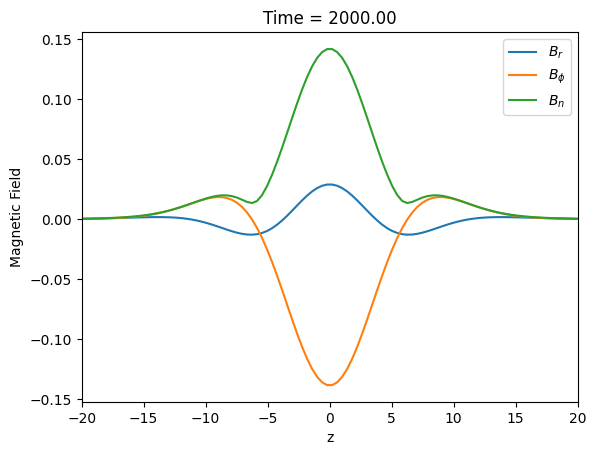

In [10]:
# Parameters
h = 0.50   
B0=10**(-3)

u=100*B0*(2**(1/2)) #we say that a dynamo is saturated when magnetic field is 100 times seed magnetic field
alpha_0 = 10.0  
q = 10.0   
Omega = 10.0  
eta_t = 10.0
t0=1.0
dt = 0.01 
T = 2000
time_step = int(T / (100 * dt))
#grid parameters
L = 10.0  
N = 100   
nt=int(T/dt)
Tlis = np.linspace(0, T, time_step)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)*B0
B_phi0=initial_condition(z)*B0

def alpha(z):
    return np.sin(np.pi * z / (32*h))

z=z/h

BnvT = np.zeros((time_step, N))
BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(z.min(), z.max())
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
line_bn, = ax.plot(z, np.zeros(N), label='$B_n$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'2magnetic_field_evolution(T={T},[-2,2]).gif', writer='pillow')
plt.show()


Gamma from linear fit for B: 0.0021295523113372132


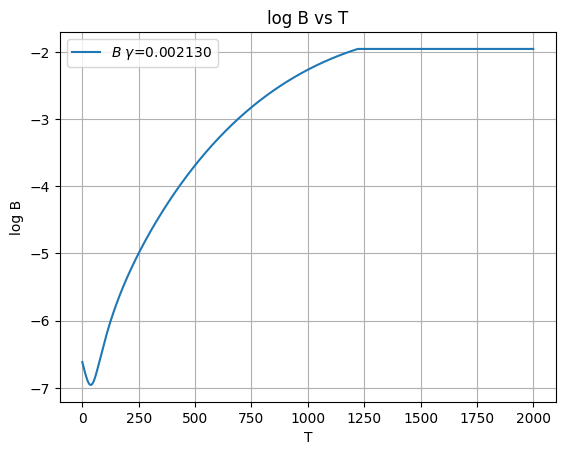

In [12]:
get_gamma(BrvT,BphivT)

Slope of the first segment: 0.004180625362950917
Slope of the second segment: -6.594251654573568e-16


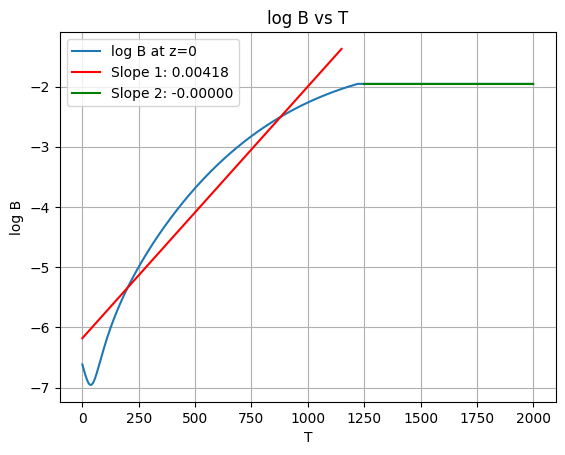

In [17]:
split_index_gamma(1150,100)

def alpha(z):
    return 0

Dynamo Number: -12.5


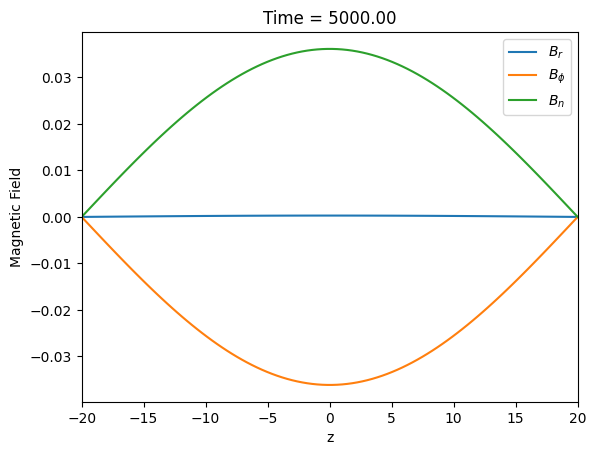

In [20]:
# Parameters
h = 0.50   
B0=10**(-3)

u=100*B0*(2**(1/2)) #we say that a dynamo is saturated when magnetic field is 100 times seed magnetic field
alpha_0 = 10.0  
q = 10.0   
Omega = 10.0  
eta_t = 10.0
t0=1.0
dt = 0.01 
T = 5000
time_step = int(T / (100 * dt))
#grid parameters
L = 10.0  
N = 100   
nt=int(T/dt)
Tlis = np.linspace(0, T, time_step)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)*B0
B_phi0=initial_condition(z)*B0

def alpha(z):
    return 0

z=z/h

BnvT = np.zeros((time_step, N))
BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(z.min(), z.max())
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
line_bn, = ax.plot(z, np.zeros(N), label='$B_n$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'2magnetic_field_evolution(T={T},[-2,2]).gif', writer='pillow')
plt.show()


Gamma from linear fit for B: 0.0003623553030580187


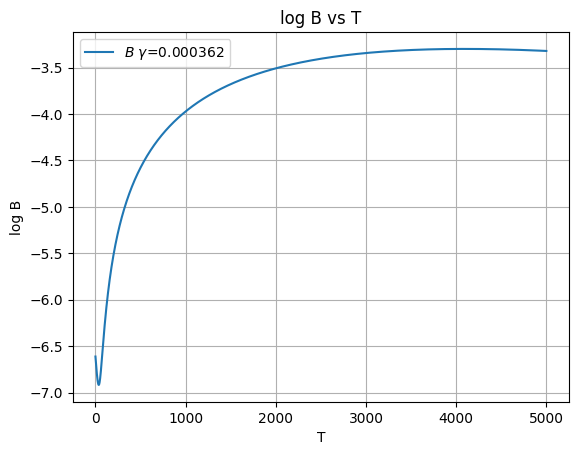

In [21]:
get_gamma(BrvT,BphivT)

Slope of the first segment: 0.002664295482406574
Slope of the second segment: 5.3801060240571526e-05


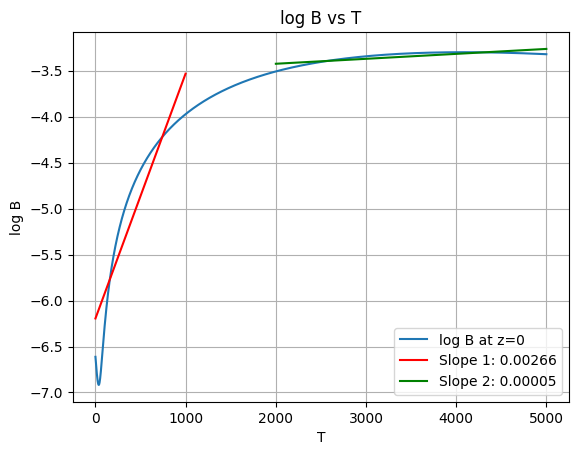

In [23]:
split_index_gamma(1000,1000)

def alpha(z):
    return 10

Dynamo Number: -12.5


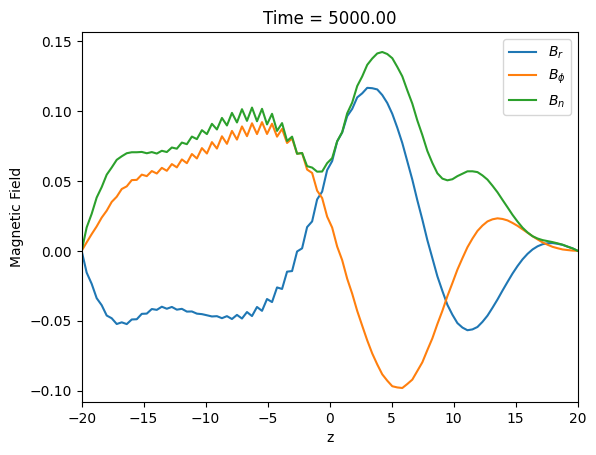

In [24]:
# Parameters
h = 0.50   
B0=10**(-3)

u=100*B0*(2**(1/2)) #we say that a dynamo is saturated when magnetic field is 100 times seed magnetic field
alpha_0 = 10.0  
q = 10.0   
Omega = 10.0  
eta_t = 10.0
t0=1.0
dt = 0.01 
T = 5000
time_step = int(T / (100 * dt))
#grid parameters
L = 10.0  
N = 100   
nt=int(T/dt)
Tlis = np.linspace(0, T, time_step)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)*B0
B_phi0=initial_condition(z)*B0

def alpha(z):
    return 10

z=z/h

BnvT = np.zeros((time_step, N))
BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(z.min(), z.max())
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
line_bn, = ax.plot(z, np.zeros(N), label='$B_n$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'2magnetic_field_evolution(T={T},[-2,2]).gif', writer='pillow')
plt.show()


Gamma from linear fit for B: 0.000259327562470704


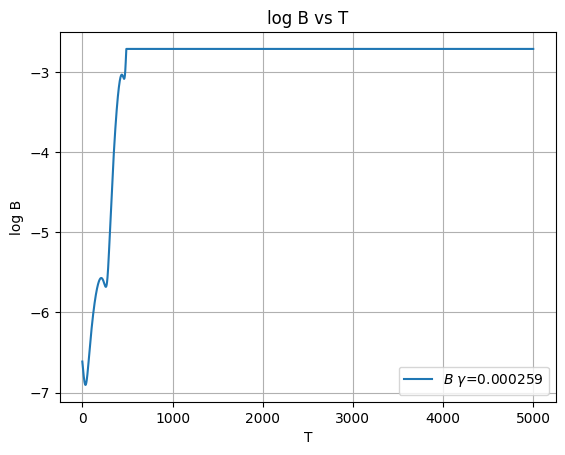

In [25]:
get_gamma(BrvT,BphivT)

Slope of the first segment: 0.009019416159169865
Slope of the second segment: 4.267125724411075e-16


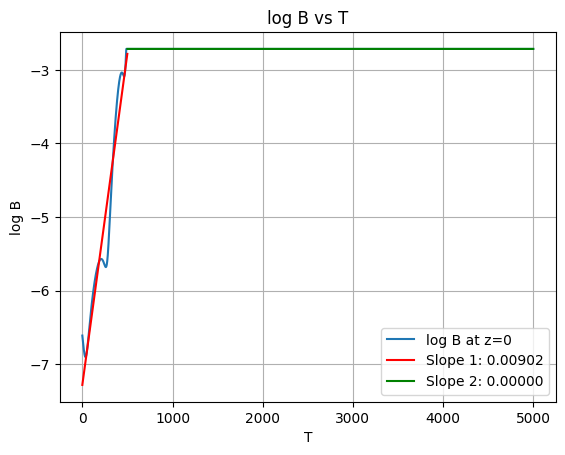

In [26]:
split_index_gamma(500)

def alpha(z):
    return -10

Dynamo Number: -12.5


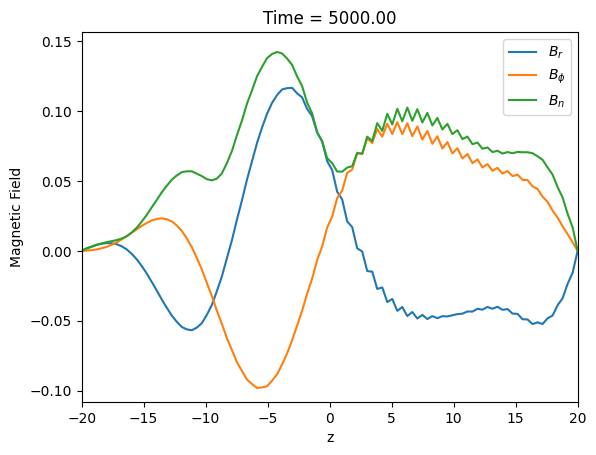

In [27]:
# Parameters
h = 0.50   
B0=10**(-3)

u=100*B0*(2**(1/2)) #we say that a dynamo is saturated when magnetic field is 100 times seed magnetic field
alpha_0 = 10.0  
q = 10.0   
Omega = 10.0  
eta_t = 10.0
t0=1.0
dt = 0.01 
T = 5000
time_step = int(T / (100 * dt))
#grid parameters
L = 10.0  
N = 100   
nt=int(T/dt)
Tlis = np.linspace(0, T, time_step)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)*B0
B_phi0=initial_condition(z)*B0

def alpha(z):
    return -10

z=z/h

BnvT = np.zeros((time_step, N))
BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(z.min(), z.max())
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
line_bn, = ax.plot(z, np.zeros(N), label='$B_n$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'2magnetic_field_evolution(T={T},[-2,2]).gif', writer='pillow')
plt.show()


Gamma from linear fit for B: 0.00025289191144812557


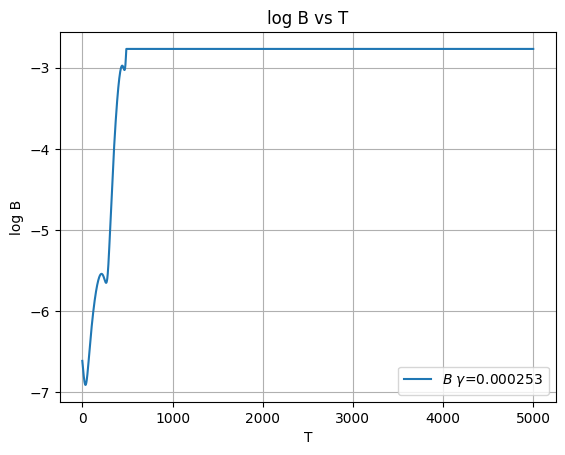

In [28]:
get_gamma(BrvT,BphivT)

Slope of the first segment: 0.009028208931276429
Slope of the second segment: 3.2940782265851185e-16


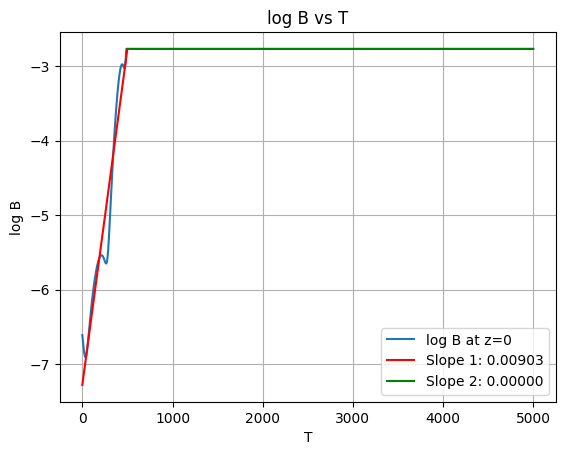

In [30]:
split_index_gamma(500)

In [ ]:
def alpha(z):
    return z/h

Dynamo Number: -12.5


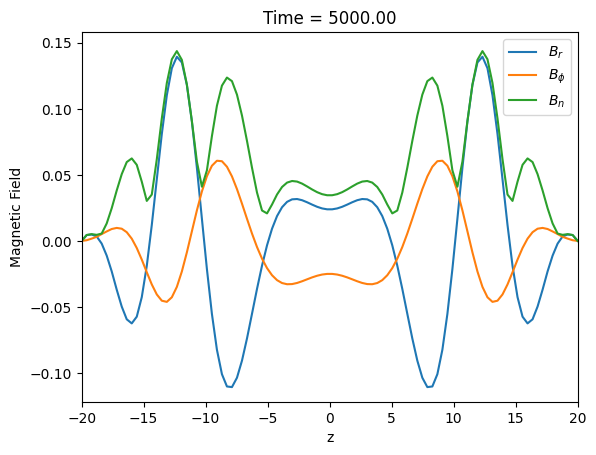

In [6]:
def alpha(z):
    return z/h
# Parameters
h = 0.50   
B0=10**(-3)

u=100*B0*(2**(1/2)) #we say that a dynamo is saturated when magnetic field is 100 times seed magnetic field
alpha_0 = 10.0  
q = 10.0   
Omega = 10.0  
eta_t = 10.0
t0=1.0
dt = 0.01 
T = 5000
time_step = int(T / (100 * dt))
#grid parameters
L = 10.0  
N = 100   
nt=int(T/dt)
Tlis = np.linspace(0, T, time_step)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)*B0
B_phi0=initial_condition(z)*B0
z=z/h

BnvT = np.zeros((time_step, N))
BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(z.min(), z.max())
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
line_bn, = ax.plot(z, np.zeros(N), label='$B_n$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'2magnetic_field_evolution(T={T}).gif', writer='pillow')
plt.show()


Gamma from linear fit for B: 0.00014368471015767425


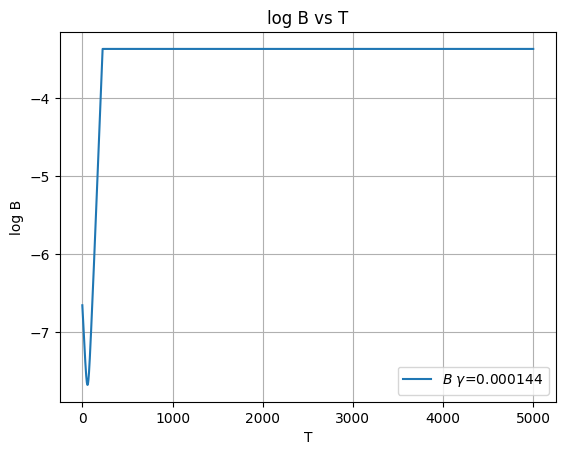

In [7]:
get_gamma(BrvT,BphivT)

Slope of the first segment: 0.01955057251183681
Slope of the second segment: 6.025972914810498e-16


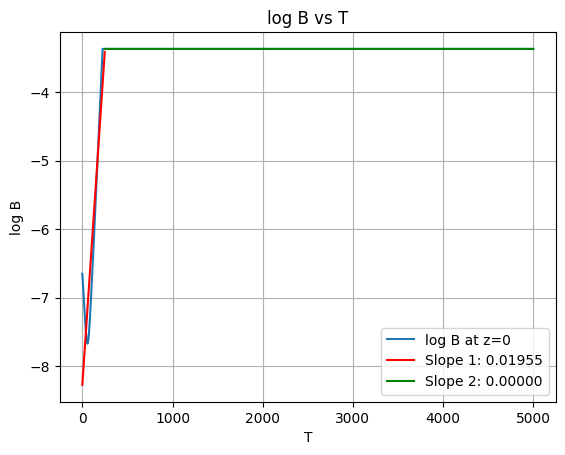

In [10]:
split_index_gamma(250)

In [ ]:
def alpha(z):
    return z/10*h

Dynamo Number: -12.5


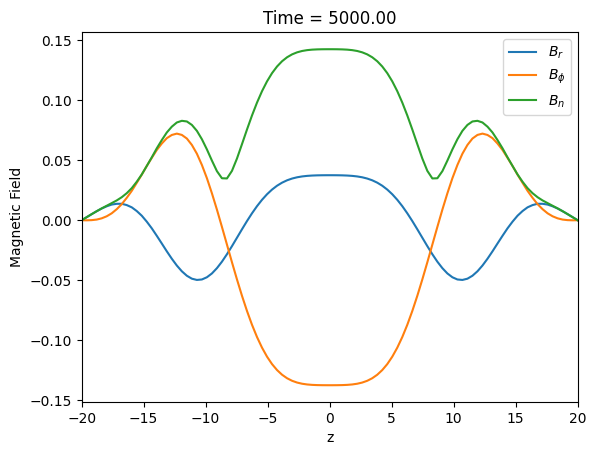

In [11]:
def alpha(z):
    return z/(10*h)
# Parameters
h = 0.50   
B0=10**(-3)

u=100*B0*(2**(1/2)) #we say that a dynamo is saturated when magnetic field is 100 times seed magnetic field
alpha_0 = 10.0  
q = 10.0   
Omega = 10.0  
eta_t = 10.0
t0=1.0
dt = 0.01 
T = 5000
time_step = int(T / (100 * dt))
#grid parameters
L = 10.0  
N = 100   
nt=int(T/dt)
Tlis = np.linspace(0, T, time_step)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((time_step,N))
BphivT = np.zeros((time_step,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)*B0
B_phi0=initial_condition(z)*B0
z=z/h

BnvT = np.zeros((time_step, N))
BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(z.min(), z.max())
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
line_bn, = ax.plot(z, np.zeros(N), label='$B_n$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=time_step, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'2magnetic_field_evolution(T={T}).gif', writer='pillow')
plt.show()


Gamma from linear fit for B: 0.0004339841765421093


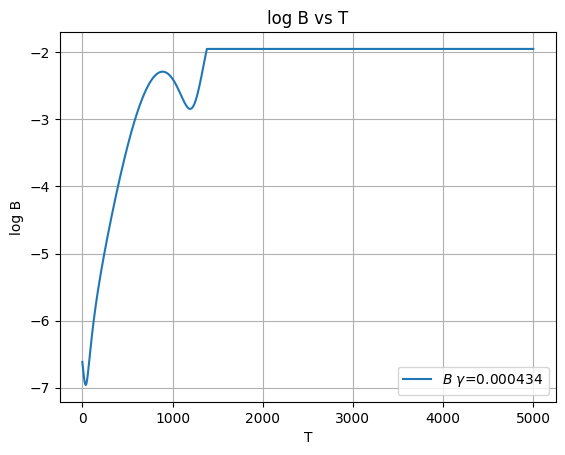

In [12]:
get_gamma(BrvT,BphivT)

Slope of the first segment: 0.002965802695129046
Slope of the second segment: 1.0570349447093189e-16


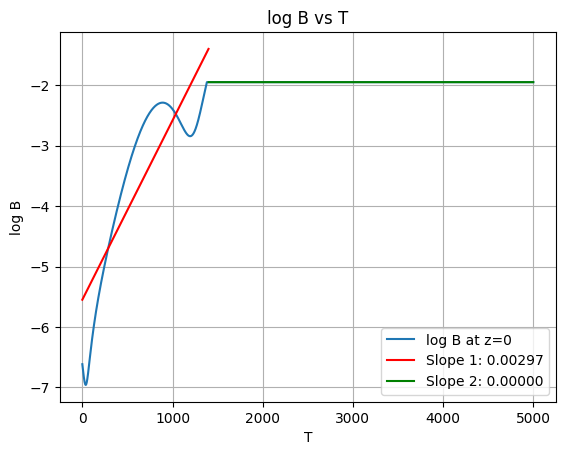

In [14]:
split_index_gamma(1400)